# Distribution fitting tutorial

In [1]:
import numpy as np
import scipy.signal as signal
from scipy.optimize import least_squares
from scipy.special import wofz

from utils import *

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

We first need to generate the fake 'detrended'-data with no noise.

In [2]:
# get the testing spectra here
gratings = 1000
x_values, synthetic_spectral_data = generate_fake_spectral_data(length=100, num_peaks=2, noise_level=0.2)
synthetic_spectral_data = np.abs(synthetic_spectral_data)
synthetic_spectral_data = np.abs(synthetic_spectral_data - arPLS(synthetic_spectral_data))
interpolated = Interpolate(x_values, synthetic_spectral_data, gratings=gratings)
interpolated.denoise_signal()

Maximum number of iterations exceeded


In [3]:
peaks = find_peaks(interpolated, window_size=10, threshold=0.3)

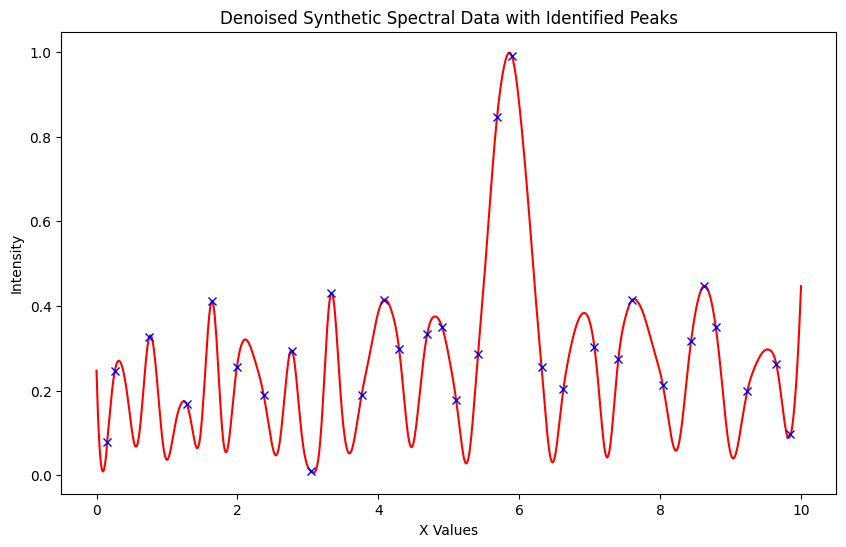

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.show()

# Gaussian fittings

In [5]:
class GaussianFitter():
    def __init__(self, InterpolatedData, peaks, threshold=0.1, parallel=True):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        self.threshold = threshold
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.sigmas = np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes,self.sigmas]).T  
        if parallel:
            self.start_params = self.params.tolist()
        else:
            self.start_params = self.params.flatten().tolist()
        # result to output
        self.result = None
                
        if parallel:
            self.approximator_parallel()
        else:
            self.approximator()
        
    """
        for serial computation
    """
    
    def approximator(self):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            max_nfev=10,
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.gaussian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def gaussian(self, x, center, amplitude, sigma):
        return amplitude * np.exp(-(x - center) ** 2 / (2 * sigma ** 2))

    def gaussian_sum(self, x, params):
        params = params.flatten().tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.gaussian(x, center, amp, sigma) for center, amp, sigma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.gaussian_sum(x_vals, params)
    """
        for parallel computation
    """
    def approximator_parallel(self, num_jobs=-1):
        results = []

        def process_peak(index):
            peak_params, peak_results, peak_error = self.fit_peak(index)
            results.append((index, peak_params, peak_results, peak_error))

        # Dynamic peak assignment and parallel processing
        num_peaks = len(self.centers)
        peak_indices = list(range(num_peaks))

        while len(peak_indices) > 0:
            # Distribute available peaks among processes
            current_indices = peak_indices[:num_jobs] if num_jobs != -1 else peak_indices
            peak_indices = peak_indices[num_jobs:]

            # Process peaks in parallel
            Parallel(n_jobs=num_jobs, backend="threading")(
                delayed(process_peak)(i) for i in current_indices
            )

        # Sort the results by peak index
        results.sort(key=lambda x: x[0])

        # Combine results
        self.params = np.concatenate([result[1] for result in results])
        self.results = np.sum([result[2] for result in results], axis=0)
        self.results /= (len(self.params) / 3.0)

        print(self.params)
        print("the error for this run is: ", np.mean(np.abs(self.y_vals - self.results)))
    
    def fit_peak(self, peak_index):
        peak_params = least_squares(self.residual_peak,
                                     self.start_params[peak_index],
                                     args=(peak_index,),
                                     bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                                     ftol=1e-6, xtol=1e-6, loss='soft_l1',
                                     f_scale=0.1).x

        peak_results = self.gaussian_sum(self.x_vals, peak_params)
        peak_error = np.mean(np.abs(self.y_vals - peak_results))
        

        return peak_params, peak_results, peak_error

    def residual_peak(self, params, peak_index):
        params_all = self.params.copy()
        params_all[peak_index * 3: (peak_index + 1) * 3] = params
        
        return self.y_vals - self.gaussian_sum(self.x_vals, params_all)

In [6]:
gauss = GaussianFitter(interpolated, peaks, parallel=False)

[ 1.45613724e-01 -4.55806096e-02  9.06200477e-02  2.80147736e-01
  1.98186843e-01  1.91227086e-01  7.66661974e-01  2.39086058e-01
  7.26701770e-02  1.15525992e+00  1.10053229e-01  4.88428342e-01
  1.63598464e+00  2.55825541e-01 -4.80140143e-02  2.02666462e+00
  1.37573594e-01  7.16146655e-02  2.41548141e+00 -9.49062672e-03
  1.46875006e-02  2.82302045e+00 -1.32406592e-01  2.71479664e-01
  3.07354204e+00 -3.15292883e-01  1.05478278e-01  3.14042535e+00
  3.72852582e-01 -7.58115511e-01  3.63537528e+00 -3.12156606e-01
  1.42969289e-01  4.15759614e+00  1.17688222e-01 -1.25541976e-01
  4.42391077e+00 -3.26172980e-01  1.88467492e-01  4.55440516e+00
  2.17116400e-01 -5.48621238e-01  4.90820765e+00  1.71913385e-02
 -2.83364072e-04  5.19124054e+00 -2.96331264e-01  3.60842067e-01
  5.35755416e+00 -4.81317345e-01  2.25982742e-01  5.69718464e+00
  3.03067113e-01 -3.37047209e-01  5.81880252e+00  6.86307711e-01
 -8.49377930e-01  6.43226576e+00 -5.62341882e-01  1.84746842e-01
  6.65081754e+00  7.92302

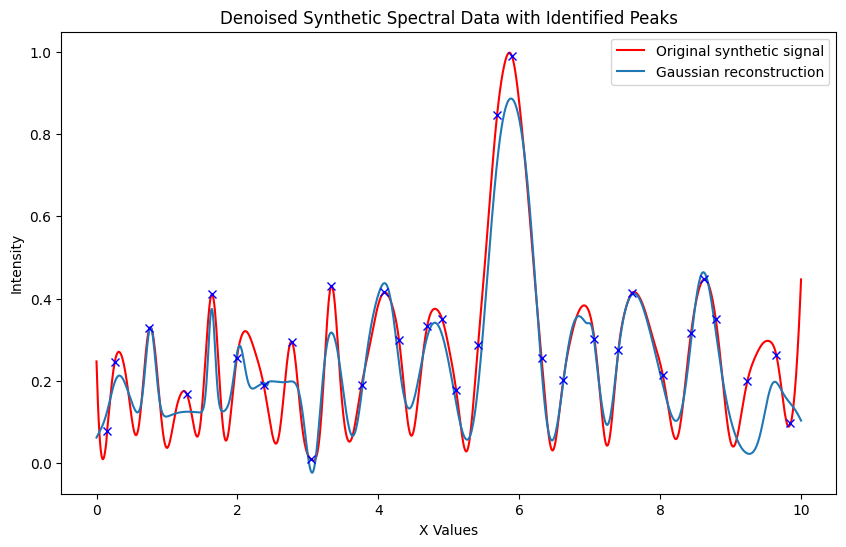

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original synthetic signal')
plt.plot(gauss.x_vals, gauss.results, label='Gaussian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Lorentzians

In [8]:
class LorentzianFitter():
    def __init__(self, InterpolatedData, peaks, threshold=0.1, max_iter=100):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        self.threshold = threshold
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gammas = [1]*len(self.centers)
        self.params = np.array([self.centers, self.amplitudes,self.gammas]).T
        self.start_params = self.params.flatten().tolist()     

        self.approximator(max_iter)
        
    def approximator(self,max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.lorentzian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def lorentzian(self, x, center, amplitude, gamma):
        return amplitude * (gamma / np.pi) / ((x - center) ** 2 + gamma ** 2)

    def lorentzian_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.lorentzian(x, centre, amp, gamma) for centre, amp, gamma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.lorentzian_sum(x_vals, params)

In [9]:
lorentz = LorentzianFitter(interpolated, peaks, max_iter=1000)

[ 4.97288270e-01 -9.99999423e+00  5.41774584e-01  8.77636516e-01
  9.99998861e+00  4.55074139e-01  3.66096192e-01  4.37722071e+00
  3.74545728e-01  9.47793400e-01 -4.32182572e+00  3.22791728e-01
  1.65620607e+00  3.43256045e+00  2.31134247e-01  1.95159802e+00
  1.19736239e+00  3.92296268e-01  1.67060637e+00 -4.92266358e+00
  2.95883974e-01  2.76850638e+00  1.18419643e-01  1.29288594e-01
  2.54892141e+00 -6.42964747e-02  1.25504707e-01  3.34022713e+00
  1.73626593e+00  2.18701029e-01  4.42070114e+00 -1.72669406e+00
  2.97216989e-01  4.40971013e+00  2.41483897e+00  4.92402213e-01
  3.34453470e+00 -2.20325015e+00  2.93723551e-01  4.35163372e+00
  1.77233079e-01  1.71183879e-01 -1.01486068e-01  4.53417608e+00
  3.59997243e-03  5.38941993e+00 -1.43827844e+00  5.44945183e-01
  5.25476275e+00 -1.11361202e-01  1.44227359e-01  5.42425180e+00
  1.43655696e+00  2.00505279e+00  5.84788766e+00  2.84199275e+00
  5.85009423e-01  6.46774233e+00 -1.41746925e-01  1.54678779e-01
  6.29197535e+00 -1.12388

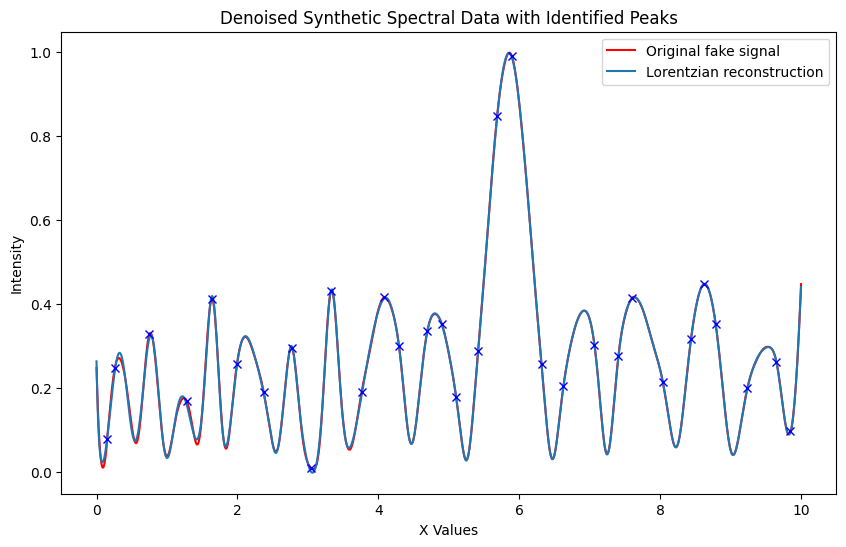

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(lorentz.x_vals, lorentz.lorentzian_sum(lorentz.x_vals, lorentz.params), label='Lorentzian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Voigt

In [11]:
class VoigtFitter():
    def __init__(self, InterpolatedData, peaks, threshold=0.1, max_iter=100, parallel=False):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        self.threshold = threshold
        self.parallel = parallel
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gauss_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.lorentz_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes, self.gauss_widths, self.lorentz_widths]).T
        if parallel:
            self.start_params = self.params.tolist()
        else:
            self.start_params = self.params.flatten().tolist()
        num_dists = len(self.centers)
        
        if parallel:
            self.approximator_parallel(num_jobs=num_dists)
        else:
            self.approximator(max_iter)
        
    def approximator(self,max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.voigt_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def voigt(self, x, center, amplitude, gauss_width, lorentz_width):
        sigma = gauss_width / np.sqrt(2 * np.log(2))
        gamma = lorentz_width
        z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2) + 1e-20)
        return amplitude * np.real(wofz(z)).astype(float) / (sigma * np.sqrt(2 * np.pi) + 1e-20)

    def voigt_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 4] for i in range(0, len(params), 4)]
        return np.sum([self.voigt(x, centre, amp, gw, lw) for centre, amp, gw, lw in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.voigt_sum(x_vals, params)
    """
        for parallel computation
    """
    def approximator_parallel(self, num_jobs=-1):
        initial_params = np.random.rand(len(self.centers) * 4)

        # Create copies of parameters for each parallel process
        peak_params_list = [initial_params[i * 4: (i + 1) * 4] for i in range(len(self.centers))]

        # Run parallelized fitting for all peaks
        results = Parallel(n_jobs=num_jobs)(
            delayed(self.fit_peak)(peak_params_list[i], i) for i in range(len(self.centers))
        )

        # Combine results and update self.params after all processes have finished
        new_params = []
        fitted_results = []
        for result in results:
            new_params.extend(result[0])
            fitted_results.append(result[1])

        self.params = np.array(new_params)
        self.results = np.sum(fitted_results, axis=0) / len(self.centers)

        print(self.params)
        print("the error for this run is: ", np.mean(np.abs(self.y_vals - self.results)))

    def fit_peak(self, peak_params, peak_index):
        result = least_squares(self.residual_peak,
                               peak_params,
                               args=(peak_index,),
                               bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                               ftol=1e-12, xtol=1e-12, loss='soft_l1',
                               f_scale=0.1)

        peak_fitted_params = result.x
        peak_results = self.voigt_sum(self.x_vals, peak_fitted_params)

        return peak_fitted_params, peak_results

    def residual_peak(self, params, peak_index):
        # Calculate residuals without modifying shared data
        temp_params = np.array(self.params)
        temp_params[peak_index * 4: (peak_index + 1) * 4] = params
        return self.y_vals - self.voigt_sum(self.x_vals, temp_params)


In [12]:
voigt = VoigtFitter(interpolated, peaks,parallel=False)

[ 2.26682371e-01  2.35797299e-01  8.91064022e-01  9.22506537e-01
  4.08920901e-01  4.62139185e-01  6.87312713e-01  7.69968700e-01
  6.66971995e-01  2.59741159e-02  1.14122320e+00  1.09100710e+00
  1.38477775e+00 -2.97201662e-01  9.08985207e-01  9.99284375e-01
  1.94103462e+00 -3.45172995e-02  9.20592712e-01  1.03101193e+00
  2.04151878e+00  3.33101773e-01  2.23880624e-01  3.74976133e-01
  2.37769811e+00 -1.04425273e-01  9.59794854e-01  1.00368887e+00
  2.76519342e+00 -7.49909737e-02  1.02214775e+00  1.03253856e+00
  3.05579216e+00 -6.19797787e-05  4.12035154e-01 -1.33973585e+00
  3.37812961e+00  6.75907236e-02  1.06939148e+00  1.04983422e+00
  3.79491623e+00 -2.22859426e-02  1.04114272e+00  1.03535084e+00
  4.04263174e+00  4.97604075e-01  4.52621811e-01  6.55305239e-01
  4.29595662e+00  1.57022497e-01  9.23493548e-01  9.88205130e-01
  4.68359381e+00  7.52227124e-02  1.04186915e+00  1.05002852e+00
  4.90349713e+00  5.63554291e-02  1.07394586e+00  1.05907622e+00
  5.11507065e+00 -1.47890

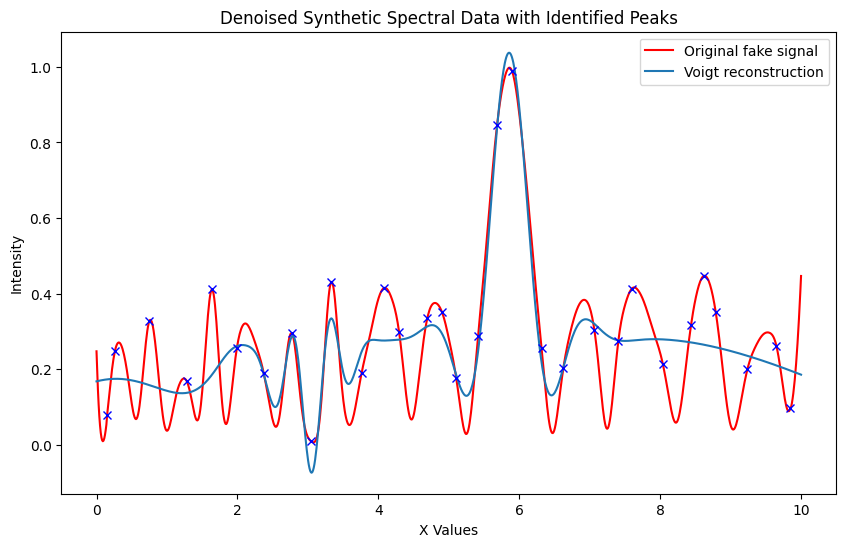

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(voigt.x_vals, voigt.results, label='Voigt reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

## Compare the results

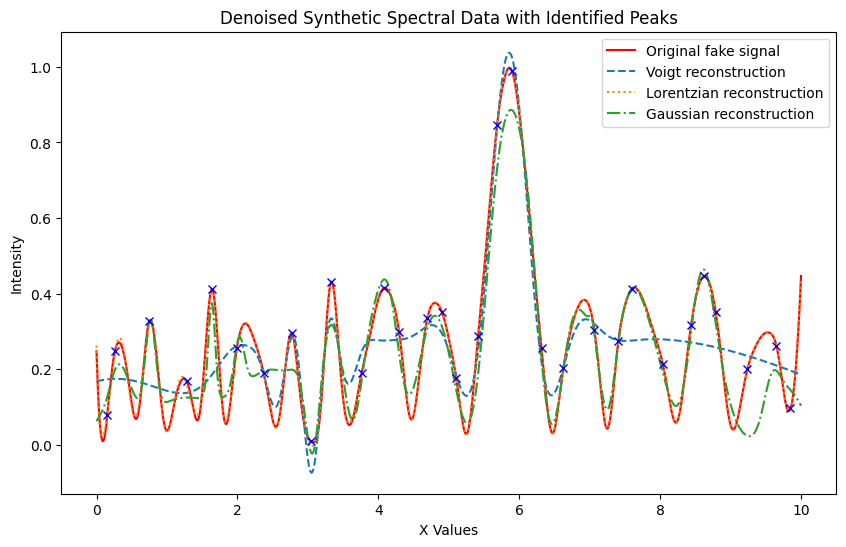

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(voigt.x_vals, voigt.results, '--', label='Voigt reconstruction')
plt.plot(lorentz.x_vals, lorentz.results, ':',label='Lorentzian reconstruction')
plt.plot(gauss.x_vals, gauss.results, '-.',label='Gaussian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [15]:
class GaussianFitter():
    def __init__(self, InterpolatedData, peaks,
                 max_iter=100):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.sigmas = np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes,self.sigmas]).T  
        self.start_params = self.params.flatten().tolist()
        # result to output
        self.result = None
                
        self.approximator(max_iter)
        
    def approximator(self, max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.gaussian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def gaussian(self, x, center, amplitude, sigma):
        return amplitude * np.exp(-(x - center) ** 2 / (2 * sigma ** 2))

    def gaussian_sum(self, x, params):
        params = params.flatten().tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.gaussian(x, center, amp, sigma) for center, amp, sigma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.gaussian_sum(x_vals, params)

class LorentzianFitter():
    def __init__(self, InterpolatedData, peaks,
                 max_iter=100):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gammas = [1]*len(self.centers)
        self.params = np.array([self.centers, self.amplitudes,self.gammas]).T
        self.start_params = self.params.flatten().tolist()     

        self.approximator(max_iter)
        
    def approximator(self, max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.lorentzian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def lorentzian(self, x, center, amplitude, gamma):
        return amplitude * (gamma / np.pi) / ((x - center) ** 2 + gamma ** 2)

    def lorentzian_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.lorentzian(x, centre, amp, gamma) for centre, amp, gamma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.lorentzian_sum(x_vals, params)
    
class VoigtFitter():
    def __init__(self, InterpolatedData, peaks, max_iter=50):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gauss_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.lorentz_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes, self.gauss_widths, self.lorentz_widths]).T
        self.start_params = self.params.flatten().tolist()
        num_dists = len(self.centers)
        
        self.approximator(max_iter)
        
    def approximator(self, max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.voigt_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def voigt(self, x, center, amplitude, gauss_width, lorentz_width):
        sigma = gauss_width / np.sqrt(2 * np.log(2))
        gamma = lorentz_width
        z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2) + 1e-20)
        return amplitude * np.real(wofz(z)).astype(float) / (sigma * np.sqrt(2 * np.pi) + 1e-20)

    def voigt_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 4] for i in range(0, len(params), 4)]
        return np.sum([self.voigt(x, centre, amp, gw, lw) for centre, amp, gw, lw in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.voigt_sum(x_vals, params)

In [16]:
# less chaotic spectra
max_iter = 300
gratings = 1000
x_values, synthetic_spectral_data = generate_fake_spectral_data(length=20, num_peaks=3) #, noise_level=0.2)
synthetic_spectral_data = np.abs(synthetic_spectral_data)
synthetic_spectral_data = np.abs(synthetic_spectral_data - arPLS(synthetic_spectral_data))
interpolated = Interpolate(x_values, synthetic_spectral_data, gratings=gratings)
interpolated.denoise_signal()
peaks = find_peaks(interpolated, window_size=5, threshold=0.5)
gauss = GaussianFitter(interpolated, peaks, max_iter=max_iter)
lorentz = LorentzianFitter(interpolated, peaks, max_iter=max_iter)
voigt = VoigtFitter(interpolated, peaks, max_iter=max_iter)

[0.48790639 0.60567763 0.46357986 2.16151142 0.40204507 0.25161944
 3.08039728 0.23210067 0.3136233  4.24268397 0.48083545 0.30276745
 5.20046166 0.47300007 0.57097558 6.30155267 0.8633446  0.33356248
 7.94101932 0.47942804 0.43656978 8.41816229 0.73804902 0.31381203
 9.93762924 0.3888686  0.34307154]
the error for this run is:  -0.0010023387378709544
[ 0.46597485  0.93337438  0.49249276  2.181785    0.23060799  0.21771186
  3.07560288  0.07412433  0.17192144  4.30300509  0.48858456  0.32425651
  5.10180112  0.46216748  0.51964957  6.28200361  1.25659693  0.45376687
  7.00104196 -0.24886891  0.31254826  8.27727776  1.35825247  0.42197549
  9.89088396  0.18353324  0.17510634]
the error for this run is:  -0.007980500934225681
[ 4.76783165e-01  2.04447344e-02  1.92132597e+00 -4.68581221e+00
  3.02720172e+00  3.64147756e-04  1.38638514e+00 -4.47785360e+00
  2.12794954e+00  5.96570243e-01  5.09907586e-01 -2.76612204e-01
  4.16630670e+00  4.07494775e-01  4.59631834e-01 -1.62973701e-01
  5.96

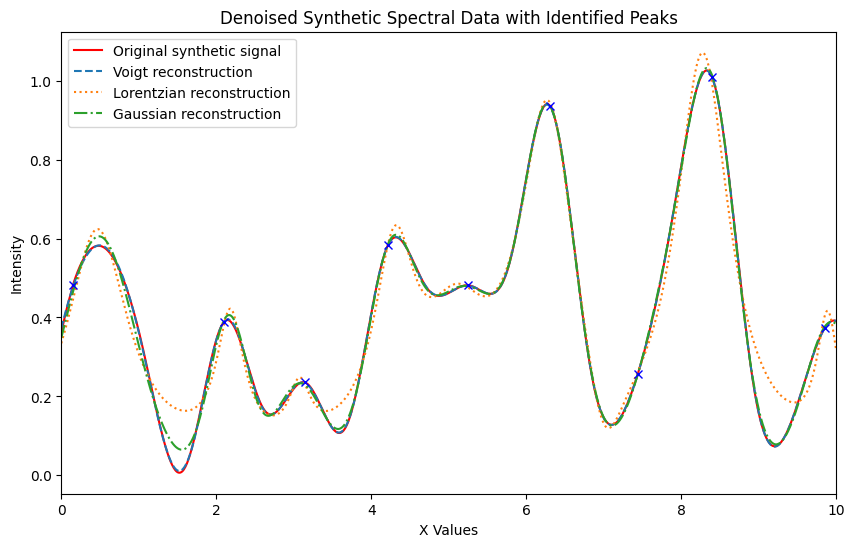

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original synthetic signal')
plt.plot(voigt.x_vals, voigt.results, '--', label='Voigt reconstruction')
plt.plot(lorentz.x_vals, lorentz.results, ':',label='Lorentzian reconstruction')
plt.plot(gauss.x_vals, gauss.results, '-.',label='Gaussian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.xlim([0,10])
plt.legend()
plt.show()